In [256]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Data manipulation
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer


from time import time

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer


# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
from absl import logging


In [257]:
# Define list of stop words and a function to normalize text

stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    #print (len(text))
    #textLower = text.astype(str)
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

['delhi', 'india', 'today', 'went', 'fli']

In [258]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/smahabha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [259]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Read in and basic overview

In [260]:
# Read csv dataset
#path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
#df = pd.read_csv(path_dataset)
#print(df.shape)
df = pd.read_csv('Capital_Projects.csv')
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] >= 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,367,367.000000,367,364,367,181,367,283,367,356,3.670000e+02,3.140000e+02,3.140000e+02,360,307.000000,309.000000
unique,4,NaN,366,327,22,19,12,30,5,307,NaN,NaN,NaN,288,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,FUEL TANK REPLACEMENT,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,09/03/2021,NaN,NaN
freq,284,NaN,2,31,81,50,168,113,172,7,NaN,NaN,NaN,17,NaN,NaN
mean,NaN,657.457766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118842e+08,1.872939e+06,1.403277e+07,NaN,53.592834,450.158576
std,NaN,259.175801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.514155e+08,3.595631e+07,7.722460e+07,NaN,216.195431,636.282607
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-2.664272e+08,-2.919002e+08,NaN,-1462.000000,-1462.000000
25%,NaN,505.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.552250e+07,0.000000e+00,-3.025000e+04,NaN,0.000000,0.000000
50%,NaN,680.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.369206e+07,0.000000e+00,1.472004e+06,NaN,0.000000,297.000000
75%,NaN,867.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980109e+07,8.537500e+05,1.994925e+07,NaN,78.000000,816.000000


## Regression Model

In [261]:
df['Description'] = df['Description'].astype(str)
df.dtypes

Date Reported As Of         object
PID                          int64
Project Name                object
Description                 object
Category                    object
Borough                     object
Managing Agency             object
Client Agency               object
Current Phase               object
Design Start                object
Budget Forecast            float64
Latest Budget Changes      float64
Total Budget Changes       float64
Forecast Completion         object
Latest Schedule Changes    float64
Total Schedule Changes     float64
dtype: object

In [262]:
# Define list of stop words and a function to normalize text

stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    #print (len(text))
    #textLower = text.astype(str)
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

['delhi', 'india', 'today', 'went', 'fli']

In [263]:
df['Normalized Description'] = df['Description'].apply(textNormalize)

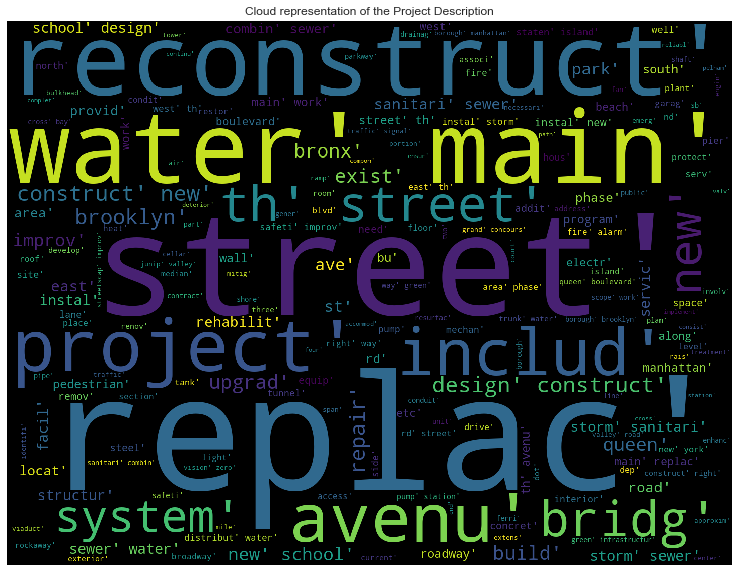

In [264]:
train_qs = pd.Series(df["Normalized Description"].tolist()).astype(str)
qs_text = " ".join(train_qs)

cloud = WordCloud(width=1440, height=1080).generate(qs_text)
plt.figure(figsize=(15, 10))
plt.title("Cloud representation of the Project Description")
plt.imshow(cloud);
plt.axis('off');

In [265]:
df['normal_joined'] = df['Normalized Description'].apply(', '.join)
df['normal_joined'] = df['normal_joined'].apply(lambda x: x.replace(', ', ' '))

In [266]:
df.head(n=3)

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined
12,09/01/2019 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,09/23/2013,1.805777e+08,-4664980.0,-4318643.37,10/09/2020,0.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
27,09/01/2019 12:00:00 AM,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,Construction,05/01/2013,6.879846e+07,1065884.0,15305457.00,02/14/2020,88.0,685.0,"[exist, main, sewag, pump, deterior, pump, sys...",exist main sewag pump deterior pump system inc...
42,09/01/2019 12:00:00 AM,18,Croton Falls Pumping Station Construction,This project will construct a new pumping stat...,Water Supply,Carmel,DEP,DEP,Construction,08/22/2003,6.787161e+07,-1399611.0,1255175.02,03/10/2020,91.0,1014.0,"[project, construct, new, pump, station, repla...",project construct new pump station replac hydr...


In [267]:
text = pd.DataFrame(df['normal_joined'])
text.head()

,normal_joined
12,th ward wwtp mandat upgrad preliminari treatme...
27,exist main sewag pump deterior pump system inc...
42,project construct new pump station replac hydr...
57,project rehabilit exist flush tunnel reconstru...
72,project consist work replac deterior plant ele...


In [268]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [269]:
df.shape

(367, 18)

In [270]:
test = df.normal_joined
temp = embed(test)


In [271]:
len(temp), len(test), type(temp.numpy())

(367, 367, numpy.ndarray)

In [272]:
embedding = temp.numpy()

In [273]:
df_embed = pd.DataFrame(embedding)

In [274]:
df_embed.shape

(367, 512)

In [275]:
df = df.reset_index(drop=True).merge(df_embed.reset_index(drop=True), left_index=True, right_index=True)

In [276]:
df.shape

(367, 530)

In [277]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-03-01 00:00:00


Date Reported As Of    datetime64[ns]
PID                             int64
Project Name                   object
Description                    object
Category                       object
                            ...      
507                           float32
508                           float32
509                           float32
510                           float32
511                           float32
Length: 530, dtype: object

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

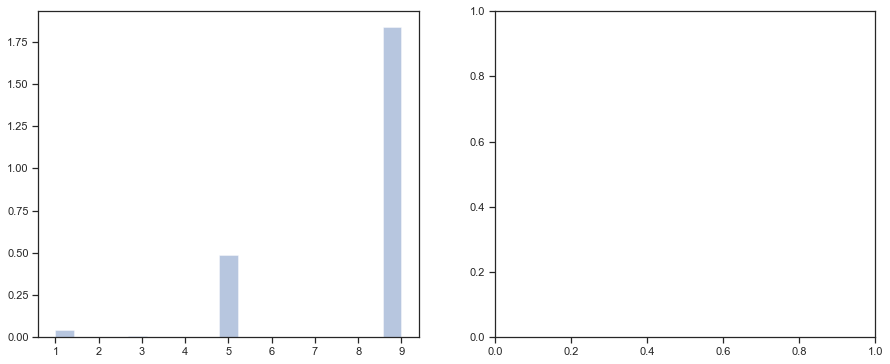

In [278]:
#### (2) #### Extract MONTH and YEAR from Date Reported
df['Month'] = df['Date Reported As Of'].dt.month
df['Year'] = df['Date Reported As Of'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df['Month'], ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df['Year'],ax=axes[1])
plt.show()

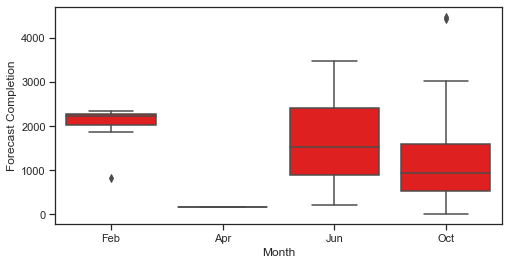

In [279]:
plt_df = df.copy()
plt_df['Forecast Completion'] = pd.to_numeric((plt_df['Forecast Completion'].copy() - min(df['Forecast Completion']))/pd.Timedelta(days=1))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Forecast Completion',
    color='red')

plt.xticks([0,1,2,3],['Feb', 'Apr', 'Jun','Oct'])
plt.show()

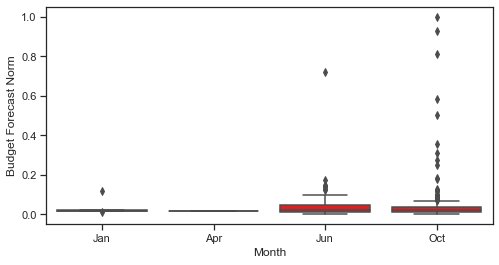

In [280]:
plt_df['Budget Forecast Norm'] = (plt_df['Budget Forecast'] - min(plt_df['Budget Forecast']))/(max(plt_df['Budget Forecast']) - min(plt_df['Budget Forecast']))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Budget Forecast Norm',
    color='red')

plt.xticks([0,1,2,3],['Jan', 'Apr', 'Jun','Oct'])
plt.show()

Max Project Duration: 9736 days 00:00:00 
 Min Project Duration: 656 days 00:00:00 


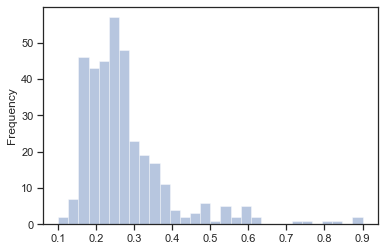

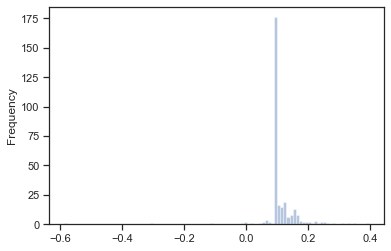

/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


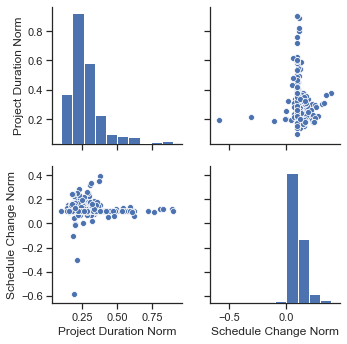

In [281]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = (0.9-0.1)*df['Latest Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1)) + 0.1
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration Norm'] = (0.9 - 0.1) * (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration) + 0.1
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
df.head()
#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=30, alpha=0.4)
df['Project Duration Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Schedule Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration Norm', 'Schedule Change Norm']])

Max Budget: 2449621616.0 
 Min Budget: 0.0
Minimum Budget Change Norm: -2.9434477574857567


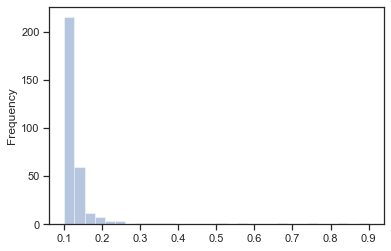

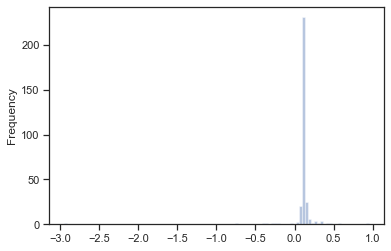

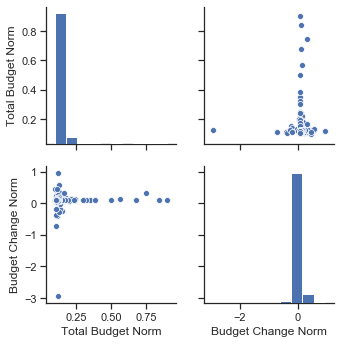

In [282]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
df['Budget Change Norm'] = (0.9-0.1)*df['Latest Budget Changes']/df['Budget Forecast'] + 0.1
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9-0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')

# Remove outliers
df = df[df['Budget Change Norm'] >= -30]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.dtypes

#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=12, alpha=0.4)
df['Total Budget Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Budget Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Total Budget Norm', 'Budget Change Norm']])

In [284]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Budget Forecast', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Year', 'Month', 'Project Duration', 'Current Phase',
                'Normalized Description', 'normal_joined']
nyc_df = nyc_df.drop(drop_columns, axis=1)
nyc_df.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,...,"Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,...,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.025416,-0.008006,-0.000732,-0.005691,0.002240,0.020430,0.029475,0.022695,0.007497,-0.026299,...,0.003215,0.003215,0.003215,0.006431,0.003215,0.003215,0.109325,0.045016,0.006431,0.006431
std,0.031784,0.034896,0.038800,0.032879,0.041170,0.046860,0.035264,0.034938,0.043092,0.035257,...,0.056705,0.056705,0.056705,0.080063,0.056705,0.056705,0.312549,0.207674,0.080063,0.080063
min,-0.073882,-0.081007,-0.080530,-0.068924,-0.084753,-0.080878,-0.074951,-0.069881,-0.088235,-0.094385,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006379,-0.035865,-0.034164,-0.028041,-0.038490,-0.018796,0.008155,-0.004742,-0.027163,-0.051565,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.026541,-0.003607,-0.001053,-0.012946,0.007730,0.028160,0.035937,0.024567,0.009710,-0.037610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.051098,0.016539,0.033014,0.016074,0.035595,0.061538,0.055015,0.049242,0.043952,0.000036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.081994,0.079271,0.077753,0.087285,0.088187,0.102419,0.091703,0.078609,0.083793,0.071417,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [285]:
nyc_df = nyc_df.dropna()
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=90)

In [286]:
nyc_train.head()

,0,1,2,3,4,5,6,7,8,9,...,"Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
200,0.065793,0.051114,0.029166,0.057947,0.039987,-0.055619,0.040281,-0.004753,-0.015154,0.031878,...,0,0,0,0,0,0,0,0,0,0
102,0.035576,0.016875,-0.011381,0.025242,0.054179,0.076535,-0.056064,-0.045114,-0.055975,0.067002,...,0,0,0,0,0,0,1,0,0,0
225,0.046794,0.006424,0.061690,0.052443,0.074611,0.057180,-0.003885,0.056213,-0.008404,-0.073044,...,0,0,0,0,0,0,0,0,0,0
66,0.062268,-0.005320,-0.046939,-0.059256,-0.044033,-0.005307,-0.009542,-0.023058,0.035656,0.010264,...,0,0,0,0,0,1,0,0,0,0
52,0.010158,0.032889,-0.009771,-0.019312,0.067005,0.039853,0.061665,0.045648,0.060099,-0.033875,...,0,0,0,0,0,0,1,0,0,0


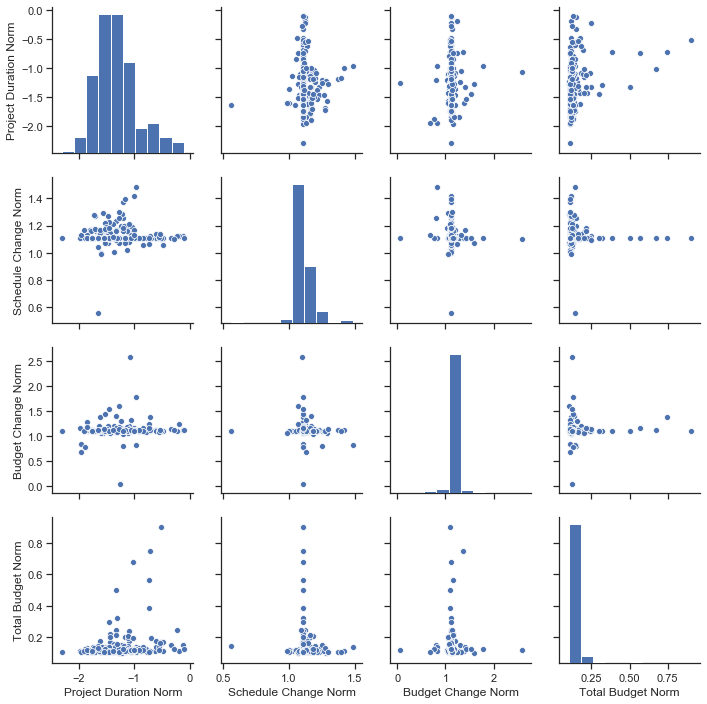

In [287]:
qual_columns = ['Project Duration Norm',	'Schedule Change Norm',
                'Budget Change Norm',	'Total Budget Norm']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
plt_df['Budget Change Norm'] = np.exp(plt_df['Budget Change Norm'])
plt_df['Total Budget Norm'] = np.abs(plt_df['Total Budget Norm'])
plt_df['Schedule Change Norm'] = np.exp(plt_df['Schedule Change Norm'])
plt_df['Project Duration Norm'] = np.log(plt_df['Project Duration Norm'])
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])
#nyc_train = plt_df

In [288]:
nyc_train[qual_columns].corr()

,Project Duration Norm,Schedule Change Norm,Budget Change Norm,Total Budget Norm
Project Duration Norm,1.000000,0.013730,0.041648,0.261421
Schedule Change Norm,0.013730,1.000000,-0.036471,-0.054797
Budget Change Norm,0.041648,-0.036471,1.000000,0.031093
Total Budget Norm,0.261421,-0.054797,0.031093,1.000000


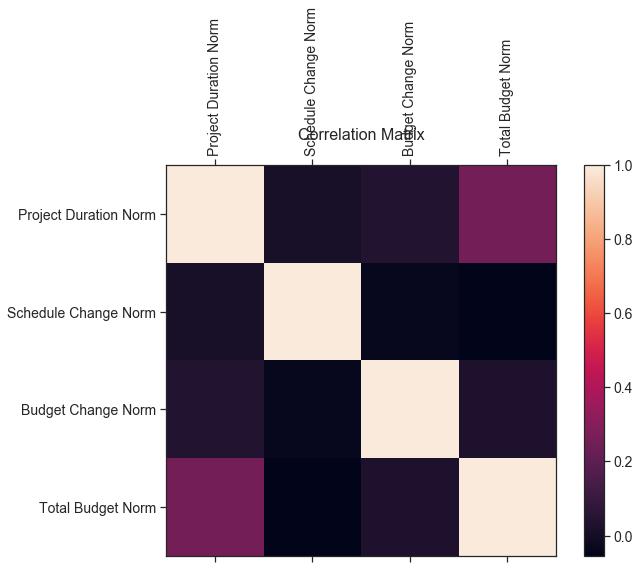

In [289]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [290]:
# Budget change
# 'Stage', 'Project Duration', 'Forecast Completion Norm', 'Schedule Change Norm',
# 'Final Budget', 'Budget Forecast Norm', 'Budget Change Norm'
nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = np.exp(nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
#X_train = nyc_train_trunc['Stage'].ravel().reshape(-1,1)
X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
#X_train['Final Budget'] = np.log(X_train['Final Budget'])
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

# Normalization or Standardization
# DateTime => numeric - (- 2013) 
# QQ plot (normal plot)

0.9704645877440262

In [291]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     3.001
Date:                Tue, 05 May 2020   Prob (F-statistic):            0.00280
Time:                        23:34:48   Log-Likelihood:                 540.82
No. Observations:                 240   AIC:                            -641.6
Df Residuals:                      20   BIC:                             124.1
Df Model:                         219                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.2275      0.948      0.240      0.813      -1.750       2.205
0                                                        -0.7142      0.237     -3.015      0.007      -1.208      -0.220
1                                                        -0.5158      0.331     -1.557      0.135      -1.207       0.175
2                                                         0.2465      0.203      1.212      0.240      -0.178       0.671
3                                                         0.3104      0.392      0.792      0.438      -0.508       1.128
4                                                        -0.0727      0.146     -0.499      0.623      -0.377       0.231
5                                                        -0.7026      0.340     -2.068      0.052      -1.411       0.006
6                                                         0.3337      0.175      1.911      0.071      -0.031       0.698
7                                                        -0.2246      0.222     -1.012      0.324      -0.688       0.238
8                                                         0.2352      0.208      1.133      0.271      -0.198       0.668
9                                                        -0.1269      0.317     -0.401      0.693      -0.788       0.534
10                                                       -0.0518      0.257     -0.202      0.842      -0.587       0.484
11                                                        0.0851      0.195      0.436      0.667      -0.322       0.492
12                                                        0.0055      0.225      0.025      0.981      -0.464       0.476
13                                                       -0.3973      0.169     -2.346      0.029      -0.751      -0.044
14                                                        0.8339      0.371      2.246      0.036       0.059       1.608
15                                                       -0.1746      0.204     -0.857      0.402      -0.600       0.250
16                                                        0.1865      0.172      1.084      0.291      -0.172       0.545
17                                                       -0.2256      0.216     -1.043      0.309      -0.677       0.226
18                                                        0.5492      0.224      2.450      0.024       0.082       1.017
19                                                       -0.0264      0.205     -0.129      0.899      -0.454       0.401
20                                                       -0.5184      0.414     -1.251      0.225      -1.383       0.346
21                               

In [292]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/smahabha/anaconda3/envs/cs109b/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                    0.000000
0                             inf
1                             inf
2                             inf
3                             inf
                           ...   
Borough_Port Jervis           inf
Borough_Queens           7.921038
Borough_Staten Island    9.685517
Borough_Upstate               inf
Borough_Valhalla              inf
Length: 554, dtype: float64

In [293]:
# Remove multi-collinearity
# Transforms

X_train = X_train_save.copy()
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     3.001
Date:                Tue, 05 May 2020   Prob (F-statistic):            0.00280
Time:                        23:35:34   Log-Likelihood:                 540.82
No. Observations:                 240   AIC:                            -641.6
Df Residuals:                      20   BIC:                             124.1
Df Model:                         219                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.2275      0.948      0.240      0.813      -1.750       2.205
0                                                        -0.7142      0.237     -3.015      0.007      -1.208      -0.220
1                                                        -0.5158      0.331     -1.557      0.135      -1.207       0.175
2                                                         0.2465      0.203      1.212      0.240      -0.178       0.671
3                                                         0.3104      0.392      0.792      0.438      -0.508       1.128
4                                                        -0.0727      0.146     -0.499      0.623      -0.377       0.231
5                                                        -0.7026      0.340     -2.068      0.052      -1.411       0.006
6                                                         0.3337      0.175      1.911      0.071      -0.031       0.698
7                                                        -0.2246      0.222     -1.012      0.324      -0.688       0.238
8                                                         0.2352      0.208      1.133      0.271      -0.198       0.668
9                                                        -0.1269      0.317     -0.401      0.693      -0.788       0.534
10                                                       -0.0518      0.257     -0.202      0.842      -0.587       0.484
11                                                        0.0851      0.195      0.436      0.667      -0.322       0.492
12                                                        0.0055      0.225      0.025      0.981      -0.464       0.476
13                                                       -0.3973      0.169     -2.346      0.029      -0.751      -0.044
14                                                        0.8339      0.371      2.246      0.036       0.059       1.608
15                                                       -0.1746      0.204     -0.857      0.402      -0.600       0.250
16                                                        0.1865      0.172      1.084      0.291      -0.172       0.545
17                                                       -0.2256      0.216     -1.043      0.309      -0.677       0.226
18                                                        0.5492      0.224      2.450      0.024       0.082       1.017
19                                                       -0.0264      0.205     -0.129      0.899      -0.454       0.401
20                                                       -0.5184      0.414     -1.251      0.225      -1.383       0.346
21                               

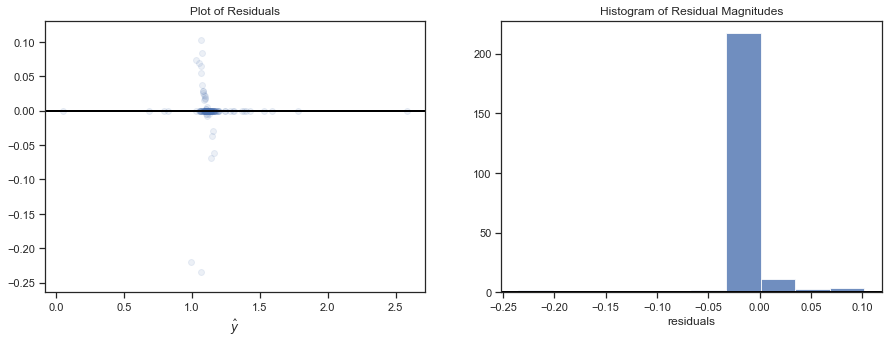

In [294]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


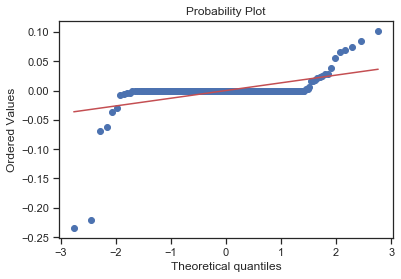

In [295]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

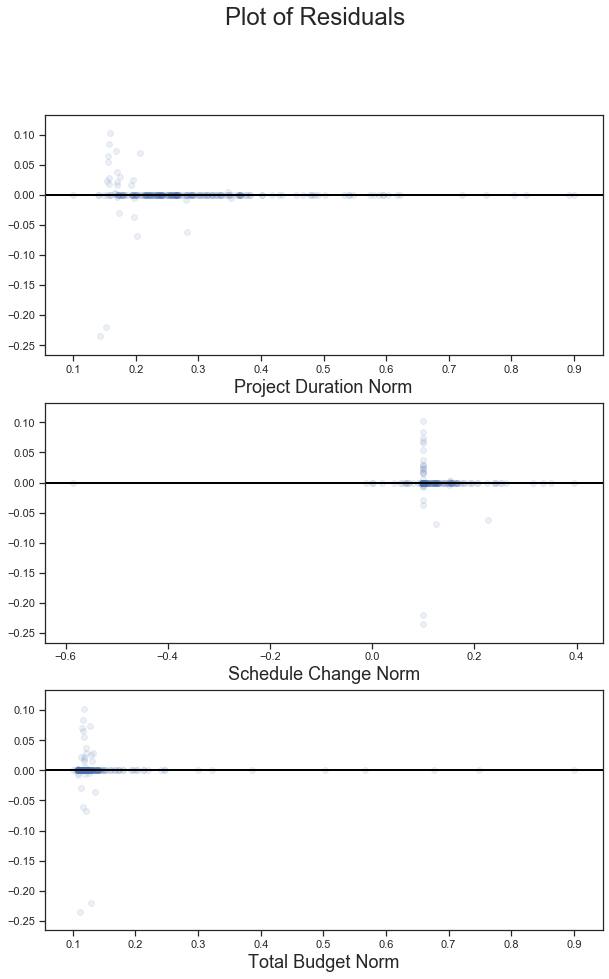

In [296]:
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [297]:
# Schedule change
y_train = np.exp(nyc_train['Schedule Change Norm'])
X_train = nyc_train.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

0.9895396071385829

In [298]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.990
Model:                              OLS   Adj. R-squared:                  0.875
Method:                   Least Squares   F-statistic:                     8.639
Date:                  Tue, 05 May 2020   Prob (F-statistic):           5.69e-07
Time:                          23:35:37   Log-Likelihood:                 851.26
No. Observations:                   240   AIC:                            -1263.
Df Residuals:                        20   BIC:                            -496.8
Df Model:                           219                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.7363      0.260      2.831      0.010       0.194       1.279
0                                                        -0.1980      0.065     -3.048      0.006      -0.334      -0.062
1                                                        -0.0499      0.091     -0.549      0.589      -0.239       0.140
2                                                        -0.0853      0.056     -1.529      0.142      -0.202       0.031
3                                                         0.1645      0.108      1.529      0.142      -0.060       0.389
4                                                         0.0855      0.040      2.139      0.045       0.002       0.169
5                                                        -0.2976      0.093     -3.193      0.005      -0.492      -0.103
6                                                         0.0039      0.048      0.082      0.936      -0.096       0.104
7                                                         0.1103      0.061      1.811      0.085      -0.017       0.237
8                                                         0.1171      0.057      2.057      0.053      -0.002       0.236
9                                                        -0.0540      0.087     -0.621      0.541      -0.235       0.127
10                                                       -0.1284      0.070     -1.823      0.083      -0.275       0.018
11                                                       -0.3433      0.053     -6.418      0.000      -0.455      -0.232
12                                                        0.0267      0.062      0.432      0.671      -0.102       0.156
13                                                        0.1642      0.046      3.533      0.002       0.067       0.261
14                                                        0.1778      0.102      1.745      0.096      -0.035       0.390
15                                                       -0.3223      0.056     -5.767      0.000      -0.439      -0.206
16                                                        0.0183      0.047      0.388      0.702      -0.080       0.117
17                                                       -0.0890      0.059     -1.499      0.149      -0.213       0.035
18                                                       -0.3414      0.061     -5.552      0.000      -0.470      -0.213
19                                                       -0.3112      0.056     -5.535      0.000      -0.429      -0.194
20                                                       -0.0480      0.114     -0.422      0.677      -0.285       0.189
21         

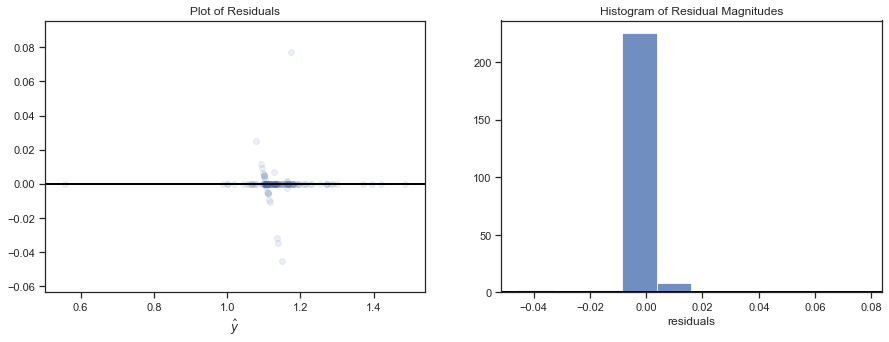

In [299]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

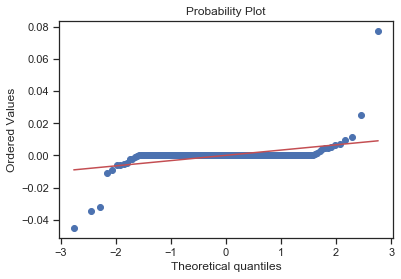

In [300]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

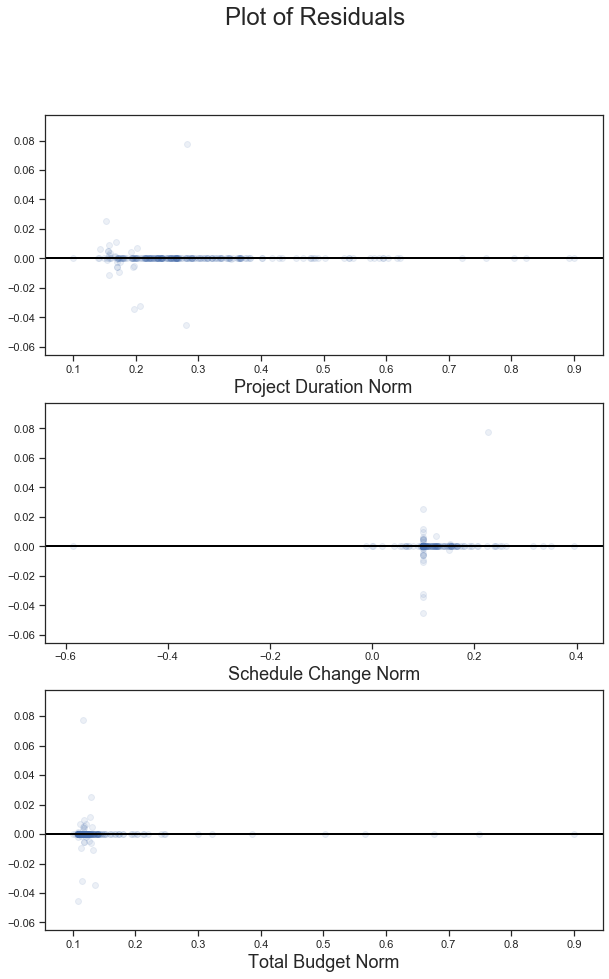

In [301]:
# Residual Plots
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()